In [1]:
from commonfunctions import *
import operator
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
def find_page_contours(img):
    img2, contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def find_largest_contour(contours):
    contours_area_list = []
    for contour in contours:
        contours_area_list.append(cv2.contourArea(contour))
        
    index, value = max(enumerate(contours_area_list), key=operator.itemgetter(1))
    return contours[index]


def findApprox(contours):
    ff = []
    approx_list = []
    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4):
            maxArea = cv2.contourArea(approx)
            ff.append(maxArea)
            approx_list.append(approx) 

    index = findMax(ff)        
    return approx_list[index]     


def findMax(ff):
    index, value = max(enumerate(ff), key=operator.itemgetter(1))
    return index

     
def resize(img, height=800):
    """ Resize image to given height """
    if (img.shape[0] > height):
        ratio = height / img.shape[0]
        return cv2.resize(img, (int(ratio * img.shape[1]), height))    
    
    
def sortCornerPoints(points):
    sorted_points = np.zeros_like(points)
    sum_points = np.sum(points,axis=1)
    sorted_points[0] = points[np.argmin(sum_points)]
    sorted_points[2] = points[np.argmax(sum_points)]
    diff_points = np.diff(points,axis=1)
    sorted_points[1] = points[np.argmin(diff_points)]
    sorted_points[3] = points[np.argmax(diff_points)]
    return sorted_points           
    
    
def transform_image(img,points):
    w = max(np.linalg.norm(points[0]-points[1]),np.linalg.norm(points[2]-points[3]))
    h = max(np.linalg.norm(points[0]-points[3]),np.linalg.norm(points[1]-points[2]))
    dest_img = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]])
    
    dest_img = dest_img.astype(np.float32)
    points = points.astype(np.float32)

    Trans_Matrix = cv2.getPerspectiveTransform(points,dest_img)
    cropped_img = cv2.warpPerspective(img, Trans_Matrix, (int(w), int(h)))
    cv2.imwrite('output/gg.jpg',img)
    cv2.imwrite('output/cropped_edge.jpg',cropped_img)
    return cropped_img


def rotate_with_lines(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

    angles = []

    for x1, y1, x2, y2 in lines[0]:
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)

    median_angle = np.median(angles)
    img_rotated = ndimage.rotate(img, median_angle)
    return img_rotated


def crop_image(path):
    img_org = cv2.imread(path)
    
    img_before = resize(cv2.imread(path))
    img_gray = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
    img_edges = cv2.bilateralFilter(img_gray, 9, 75, 75)
    img_edges = cv2.adaptiveThreshold(img_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    img_edges = cv2.medianBlur(img_edges, 11)
    img_edges = cv2.Canny(img_edges,200, 250)
    img_edges = cv2.morphologyEx(img_edges, cv2.MORPH_CLOSE, np.ones((5, 11)))

    cv2.imwrite('output/2_edge.jpg',img_edges)

    pageContour = find_page_contours(img_edges)
    con = find_largest_contour(pageContour)
    epsilon = 0.01*cv2.arcLength(con,True)
    approx = cv2.approxPolyDP(con,epsilon,True)
    ff= findApprox(pageContour)

    corner_points = sortCornerPoints(ff[:,0])*(img_org.shape[0]/800)
    cv2.drawContours(img_before,[ff],0,(0,0,255),3)
    cv2.imwrite('output/after_contour.jpg',img_before)

    transformed_img = transform_image(img_org,corner_points)
    return rotate_with_lines(transformed_img)

In [40]:
def segment_image(img):

    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray, 50, 150)
    h_img,w_img,x = img.shape
    thrsh = 120
    img_edges = cv2.resize(img_edges, (w_img, h_img)) 
    img_edges[img_edges>=thrsh] = 255
    img_edges[img_edges<thrsh] = 0
    kernel = np.ones((50,50), np.uint8)
    dilated_img = cv2.dilate(img_edges, kernel, iterations=1)
    h,w = dilated_img.shape
    flag = 0
    cropHeight = 0
    imgIndex = 0
    cropped_imgs = list()
    bound = int(h/45)
    for y in range(h):
        if dilated_img[y,int(w/2)] == 255 and flag == 0:
            y_start = y
            flag = 1
        if dilated_img[y,int(w/2)] == 255 and flag == 1:
            cropHeight +=1
        if dilated_img[y,int(w/2)] == 0 and flag == 1:
            flag = 0  
            if cropHeight < 100:
                continue
            if imgIndex == 0:
                imgIndex+=1
                cropHeight = 0
                continue
            crop_img = img[y_start-bound:y_start+cropHeight+bound, 50:w-60]
            cropped_imgs.append(crop_img)
            filename = 'output/cropped' + str(imgIndex) + '.jpg'
            cv2.imwrite(filename,crop_img)
            cropHeight = 0
            imgIndex+=1
    return cropped_imgs

In [4]:
def detect_ellipses(image):
    gray_image = rgb2gray(image)*255
    gray_image = (gray_image.astype(np.uint8)<128) * np.uint8(255)
    kernel = np.ones((3,3), np.uint8)
    gray_image = cv2.erode(gray_image, kernel, iterations=5)
    gray_image = cv2.dilate(gray_image, kernel, iterations=8)
    ellipses = gray_image>128
    #gray_image[ellipses] = (255, 0, 0)
    return ellipses

In [5]:
def remove_lines_seg(img):
    #bar(np.arange(img.shape[0]), 80 - np.sum(img,axis=1))
    y = 80 - np.sum(img,axis=1)
    maxnum = np.max(y) - 3
    number_of_peaks = np.sum(y>maxnum)
    thickness = number_of_peaks//5                         
    img[y>maxnum] = 1
    img_modified = img.copy()
    img_modified = cv2.medianBlur(img_modified.astype(np.uint8), 5)
    h, w = img_modified.shape
    bound  = 6  
    for y in range(bound , h - bound):
        for x in range(w):
            if img_modified[y,x] == 1 and img_modified[y-bound,x] == 0 and img_modified[y+bound,x] ==0:
                img_modified[y,x] = 0
    return img_modified

In [6]:
def remove_lines(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bin_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    #vertical 
    bin_img = bin_img/255
    delta = 80
    for i in range(0,bin_img.shape[1],delta):
        bin_img[:,i:i+delta] = remove_lines_seg(bin_img[:,i:i+delta])
    kernel = np.ones((3,3),np.uint8)
    eroded_img = cv2.erode(bin_img,kernel,iterations = 2)
    closed_img = cv2.dilate(eroded_img,kernel,iterations = 2)*255
    return closed_img

In [7]:
# Removal of ellipses and thresholding the image
def remove_ellipses(ellipses,bin_img):
    x_bin = bin_img > 128
    #print(ellipses.shape, x_bin.shape)
    x_bin[ellipses] = True
    x_bin = x_bin.astype(np.uint8)*255
    #x_bin = median(x_bin)
    cv2.imwrite("test2.jpg",x_bin)
    return x_bin

In [8]:
def detect_centers(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_gray[ellipses] = 255
    img_gray[img_gray != 255] = 0
    cv2.imwrite('ellipses.jpg',img_gray)
    lbl = ndimage.label(img_gray)[0]
    numberOfEllipses = np.max(lbl)
    arr = list(range(1,numberOfEllipses+1))
    centers = ndimage.measurements.center_of_mass(img_gray, lbl,arr)
    centers = np.asarray(centers).astype(int)
    return centers

In [9]:
def segment_symbols(line):
    line = line.astype(np.uint8)
    line = np.logical_not(line)
    line = line.astype(np.uint8)
    _, contours, hierarchy = cv2.findContours(line.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    hierarchy = hierarchy[0]

    contours = np.asarray(contours)

    mask = (hierarchy[:, 3] == 0).astype('int')

    #print(mask)
    #cv2.imwrite("test3.jpg",closing*255)

    #contours = contours[np.where(mask)]
    
    bounding_rect = []
    for i in range(0, len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])
        if (w*h)<500:
            continue
        #print(w*h)    
        bounding_rect.append((int(x), int(y), int(w), int(h)))
    
    return bounding_rect
    
    
    
def draw_bounding_rect(line,bounding_rect):
    for x, y, w, h in bounding_rect:        
        line = cv2.rectangle(line,(int(x),int(y)),(int(x+w),int(y+h)),0,2)
    cv2.imwrite("test4.jpg",line*255)  
    
    
    
    
def draw_histogram(line,boundingrects):
    for rect in boundingrects:
        x,y,w,h = rect
        symbol = line[int(y):int(y+h),int(x):int(x+w)]
        if (len(symbol)==0):
            continue
        if (np.count_nonzero(symbol)==0):
            continue
        bar(np.arange(symbol.shape[1]), np.sum(symbol,axis=0))
        show_images([symbol])

    

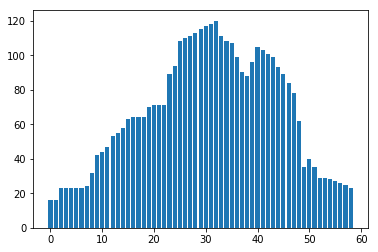

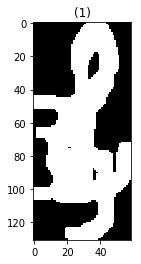

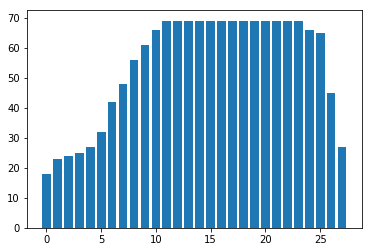

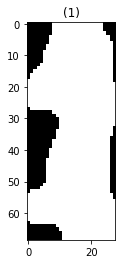

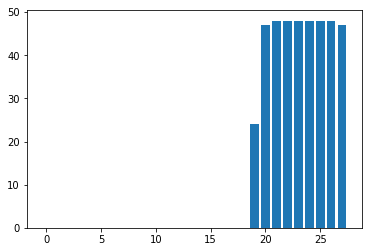

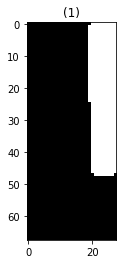

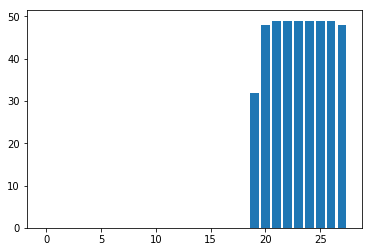

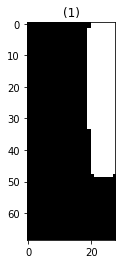

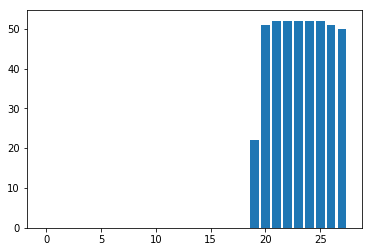

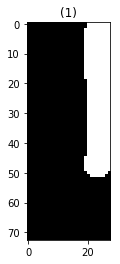

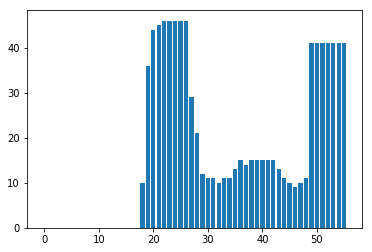

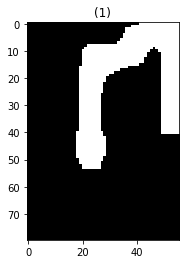

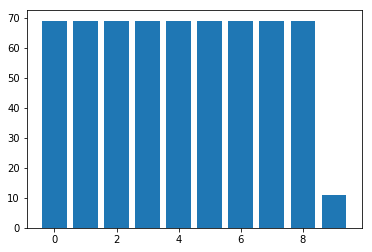

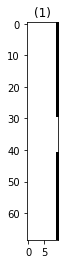

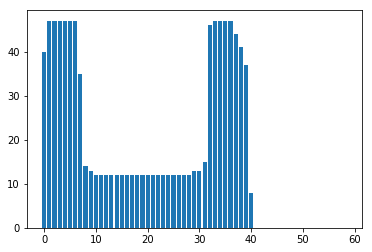

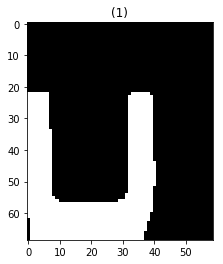

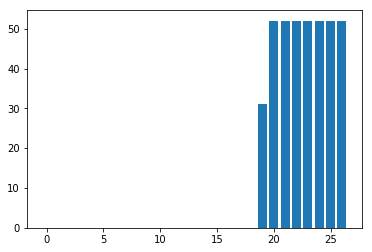

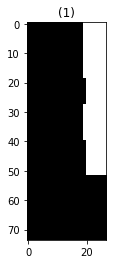

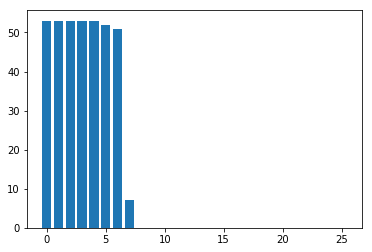

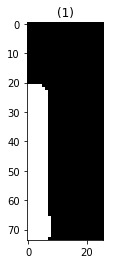

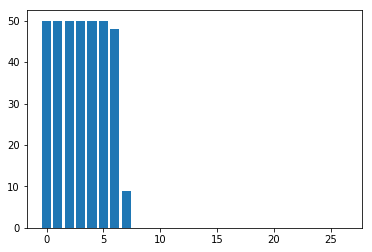

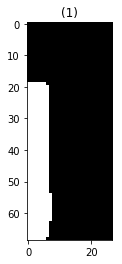

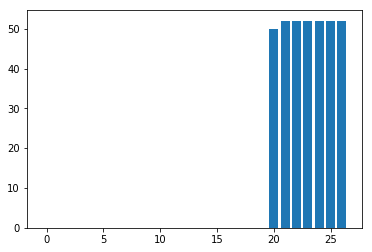

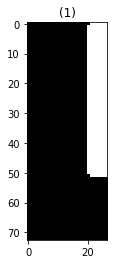

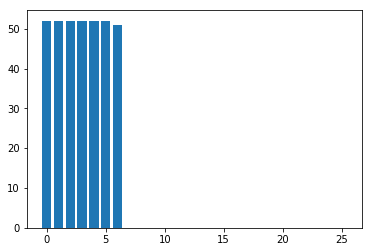

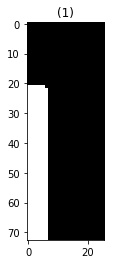

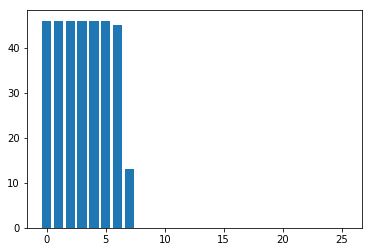

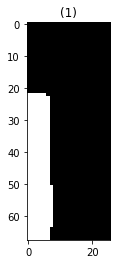

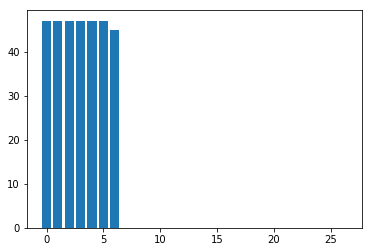

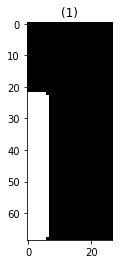

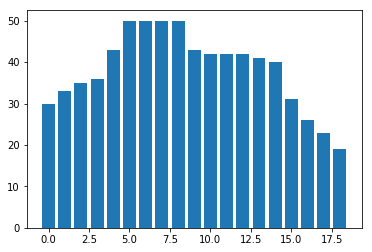

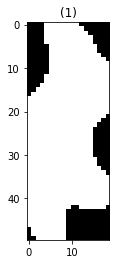

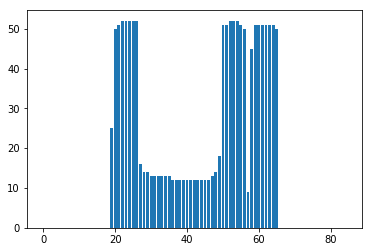

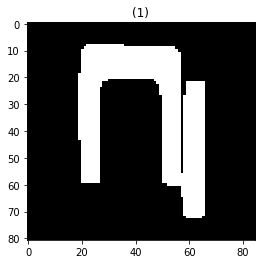

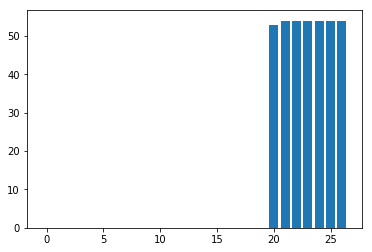

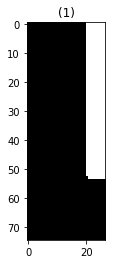

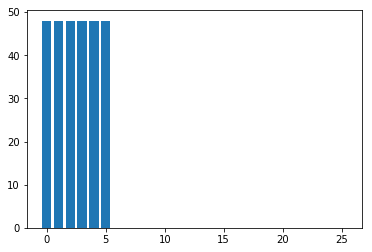

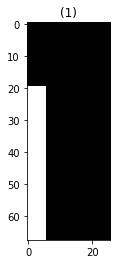

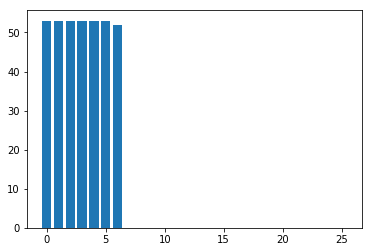

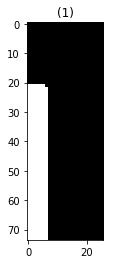

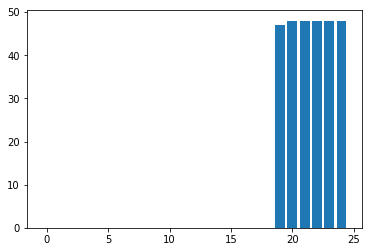

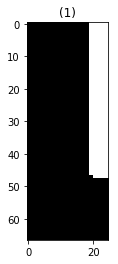

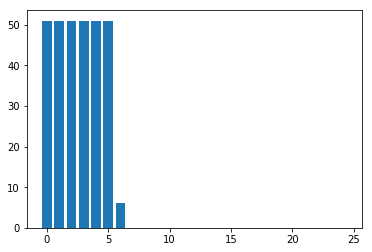

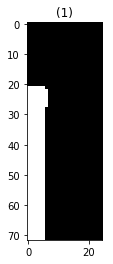

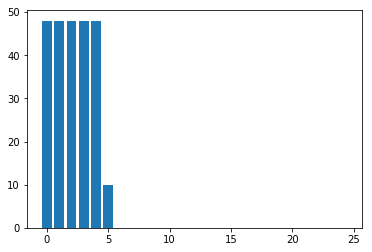

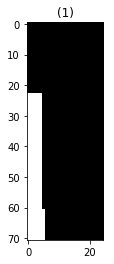

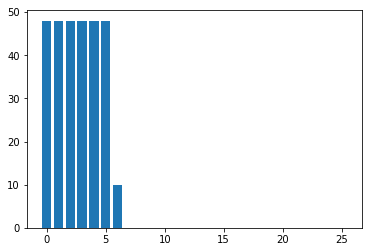

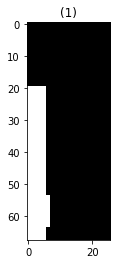

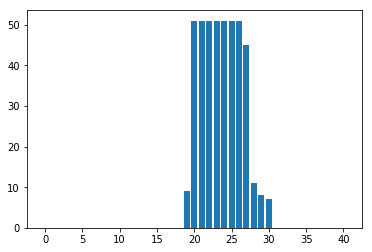

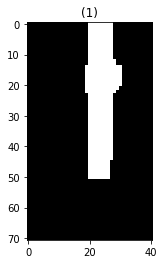

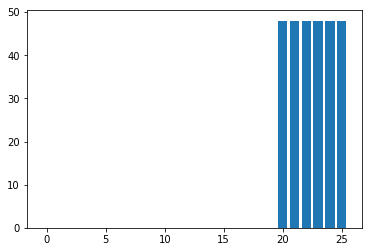

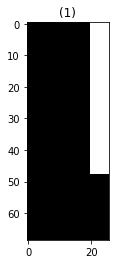

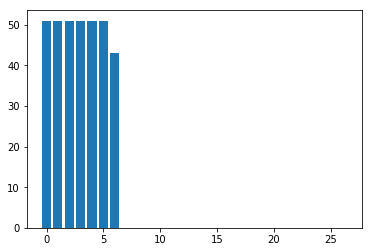

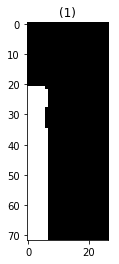

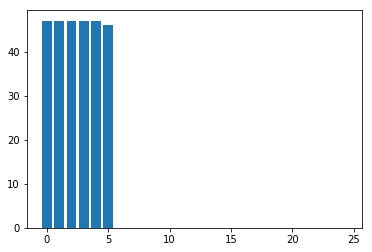

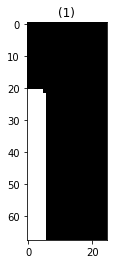

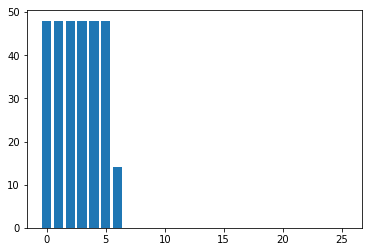

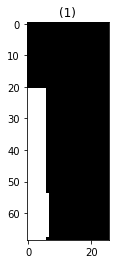

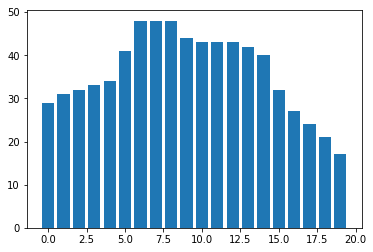

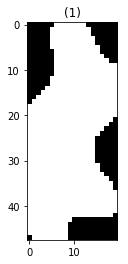

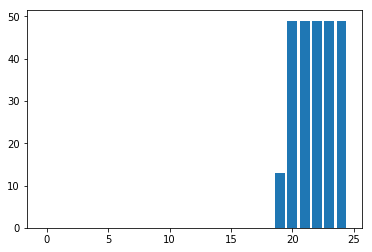

In [ ]:
#### Main ######
img = crop_image('imgs/2.jpg')
segments = segment_image(img)
imgIndex = 1
segnum = 0
for segment in segments:
    bin_img = remove_lines(segment)
    df = bin_img.astype(np.uint8)
    df = np.logical_not(df)
    df = df.astype(np.uint8)
    ellipses = detect_ellipses(segment)
    centers  = detect_centers(segment)
    
    bounding_rect = segment_symbols(bin_img)
    bounding_rect.sort(key=lambda x: x[0])  
    img_no_ellipses = remove_ellipses(ellipses,bin_img)
    img_no_ellipses = cv2.medianBlur(img_no_ellipses.astype(np.uint8),5)
    img_no_ellipses = img_no_ellipses.astype(np.uint8)
    img_no_ellipses = np.logical_not(img_no_ellipses)
    kernel = np.ones((3,3),np.uint8)
    img_no_ellipses = img_no_ellipses.astype(np.uint8)  
    img_no_ellipses = cv2.dilate(img_no_ellipses, kernel, iterations=2)
    cv2.imwrite('test8.jpg',img_no_ellipses*255)

    #draw_bounding_rect(img_no_ellipses,bounding_rect)
    if (segnum==0):
        draw_histogram(img_no_ellipses,bounding_rect)
    segnum += 1
    break
    #filename = 'ellipses' + str(imgIndex) + '.jpg'
    #cv2.imwrite(filename,segment)
    #imgIndex+=1
    

In [12]:
def getLinesSpace(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_bin =  cv2.Canny(img_gray, 50, 150)
    img_horizontal = np.copy(img_bin)
    kernel = np.ones((3,3), np.uint8)
    img_horizontal = cv2.dilate(img_horizontal, kernel, iterations=1)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    img_horizontal = cv2.erode(img_horizontal, kernel, iterations=6)
    img_horizontal = cv2.dilate(img_horizontal, kernel, iterations=16)
    kernel = np.ones((4,2), np.uint8)
    img_horizontal = cv2.erode(img_horizontal, kernel, iterations=1)
    cv2.imwrite('output/Hor_Lines.jpg',img_horizontal)

    lines = list()
    h,w = img_horizontal.shape
    for y in range(h):
        count = 0
        for x in range(int(w/2)-20,int(w/2)+20):
            if img_horizontal[y,x] ==255:
                count += 1
            if count >= 10:
                lines.append(y)
                if len(lines)>1 and y - lines[-2] < 15:
                    lines.remove(y)
                break
    avgSpace = 0            
    for x in range(1,len(lines)):
        avgSpace += (lines[x] - lines[x-1])
    avgSpace /= 4
    return int(avgSpace)


#img = cv2.imread('output/cropped4.jpg')
#print(getLinesSpace(img))

In [13]:
# May be used to allow for ellipse color detection later on
def fill_ellipses(image):
    data = np.copy(image)
    # finds and number all disjoint white regions of the image
    is_white = data > 128
    labels, n = scipy.ndimage.measurements.label(is_white)

    # get a set of all the region ids which are on the edge - we should not fill these
    on_border = set(labels[:,0]) | set(labels[:,-1]) | set(labels[0,:]) | set(labels[-1,:])

    for label in range(1, n+1):  # label 0 is all the black pixels
        if label not in on_border:
            # turn every pixel with that label to black
            data[labels == label] = 0
    return data